Objective functions can optionally take in step, budget, and generations.

step - The same objective function will be run for #evaluation_early_stop_steps, the current step will be passed into the function as an interger. (This is useful for getting a single fold of cross validation for example).

budget - A parameter that varies over the course of the generations. Gets passed into the objective function as a float between 0 and 1. If the budget of the previous evaluation is less than the current budget, it will get re-evaluated. Useful for using smaller datasets earlier in training.

generations - an int corresponding to the current generation number.


In [1]:
#knapsack problem
import numpy as np
import tpot2
import random
import matplotlib.pyplot as plt
from dask.distributed import Client, LocalCluster

class SubsetSelector(tpot2.BaseIndividual):
    def __init__(   self,
                    values,
                    initial_set = None,
                    k=1, #step size for shuffling
                ):

        if isinstance(values, int):
            self.values = set(range(0,values))
        else:
            self.values = set(values)


        if initial_set is None:
            self.subsets = set(random.choices(values, k=k))
        else:
            self.subsets = set(initial_set)

        self.k = k

        self.mutation_list = [self._mutate_add, self._mutate_remove]
        self.crossover_list = [self._crossover_swap]
        

    def mutate(self,):
        mutation_list_copy = self.mutation_list.copy()
        random.shuffle(mutation_list_copy)
        for func in mutation_list_copy:
            if func():
                return True
        return False

    def crossover(self, ind2):
        crossover_list_copy = self.crossover_list.copy()
        random.shuffle(crossover_list_copy)
        for func in crossover_list_copy:
            if func(ind2):
                return True
        return False

    def _mutate_add(self,):
        not_included = list(self.values.difference(self.subsets))
        if len(not_included) > 1:
            self.subsets.update(random.sample(not_included, k=min(self.k, len(not_included))))
            return True
        else:
            return False

    def _mutate_remove(self,):
        if len(self.subsets) > 1:
            self.subsets = self.subsets - set(random.sample(list(self.subsets), k=min(self.k, len(self.subsets)-1) ))

    def _crossover_swap(self, ss2):
        diffs = self.subsets.symmetric_difference(ss2.subsets)

        if len(diffs) == 0:
            return False
        for v in diffs:
            self.subsets.discard(v)
            ss2.subsets.discard(v)
            random.choice([self.subsets, ss2.subsets]).add(v)
        
        return True

    def unique_id(self):
        return str(tuple(sorted(self.subsets)))

def individual_generator():
    while True:
        yield SubsetSelector(values=np.arange(len(values)))


values = np.random.randint(200,size=100)
weights = np.random.random(200)*10
max_weight = 50

def simple_objective(ind, **kwargs):
    subset = np.array(list(ind.subsets))
    if len(subset) == 0:
        return 0, 0

    total_weight = np.sum(weights[subset])
    total_value = np.sum(values[subset])

    if total_weight > max_weight:
        total_value = 0

    return total_value, total_weight

objective_names = ["Value", "Weight"]
objective_function_weights = [1,-1]



evolver = tpot2.BaseEvolver(   individual_generator=individual_generator(), 
                                objective_functions=[simple_objective],
                                objective_function_weights = objective_function_weights,
                                bigger_is_better = True,
                                population_size= 100,
                                objective_names = objective_names,
                                generations= 100,
                                n_jobs=1,
                                verbose = 1,

)

evolver.optimize()

Generation:   0%|          | 0/100 [00:00<?, ?it/s]

In [17]:
final_population_results = evolver.population.evaluated_individuals
final_population_results.reset_index(inplace=True)
final_population_results = final_population_results.rename(columns = {'index':'Selected Index'})

best_idx = final_population_results["Value"].idxmax()
best_individual = final_population_results.loc[best_idx]['Individual']
print("best subset", best_individual.subsets)
print("Best value {0}, weight {1}".format(final_population_results.loc[best_idx, "Value"],final_population_results.loc[best_idx, "Weight"]))
print()

print("All results")
final_population_results

best subset {0, 1, 8, 12, 16, 17, 27, 33, 39, 40, 49, 60, 61, 62, 63, 68, 71, 72, 75, 80, 83, 88, 93, 94}
Best value 3303.0, weight 49.904270360434694

All results


,Selected Index,Value,Weight,Parents,Variation_Function,Individual,Generation
0,"(12,)",111.0,2.311217,NaN,NaN,<__main__.SubsetSelector object at 0x7f8f6ab1b...,0.0
1,"(4,)",53.0,9.250839,NaN,NaN,<__main__.SubsetSelector object at 0x7f8f679b8...,0.0
2,"(49,)",142.0,1.245016,NaN,NaN,<__main__.SubsetSelector object at 0x7f8f6ab1a...,0.0
3,"(41,)",165.0,6.678665,NaN,NaN,<__main__.SubsetSelector object at 0x7f8f6ab1a...,0.0
4,"(52,)",149.0,4.166724,NaN,NaN,<__main__.SubsetSelector object at 0x7f8f6ab1a...,0.0
...,...,...,...,...,...,...,...
9995,"(0, 1, 8, 12, 16, 17, 27, 33, 39, 40, 48, 49, ...",0.0,56.274519,"((0, 1, 8, 12, 16, 17, 27, 33, 39, 40, 49, 60,...",mutate,<__main__.SubsetSelector object at 0x7f8f67c93...,99.0
9996,"(8, 27, 30, 33, 65, 80, 83, 94)",871.0,11.654615,"((8, 27, 30, 33, 80, 83, 94),)",mutate,<__main__.SubsetSelector object at 0x7f8f67c93...,99.0
9997,"(27, 48, 60, 80, 83, 94)",764.0,10.725417,"((27, 33, 60, 80, 83, 94),)",mutate,<__main__.SubsetSelector object at 0x7f8f67c93...,99.0
9998,"(8, 27, 30, 33, 58, 65, 80, 83, 94)",924.0,20.673691,"((8, 27, 30, 33, 80, 83, 94),)",mutate,<__main__.SubsetSelector object at 0x7f8f67c93...,99.0


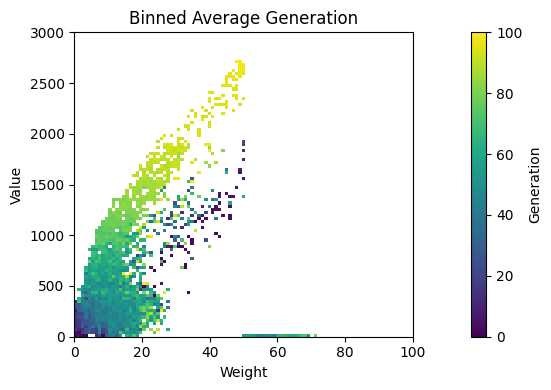

In [15]:
from scipy.stats import binned_statistic_2d

y = final_population_results["Value"]
x = final_population_results["Weight"]
c = final_population_results["Generation"]

x_bins = np.linspace(0, 100, 100)
y_bins = np.linspace(0, 3000, 100)

ret = binned_statistic_2d(x, y, c, statistic=np.mean, bins=[x_bins, y_bins])

fig, ax1 = plt.subplots(1, 1, figsize=(12, 4))

im = ax1.imshow(ret.statistic.T, origin='lower', extent=(0,100,0,3000), vmin=0, vmax=100, aspect=.03)
ax1.set_xlabel("Weight")
ax1.set_ylabel("Value")
ax1.set_title("Binned Average Generation")

cbar = fig.colorbar(im,)
cbar.set_label('Generation')
plt.tight_layout()